In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from pathlib import Path

from lmfit import Parameters, minimize, fit_report
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

# Global plot parameters
plt.rcParams.update({'font.size':20, 'lines.markersize':9})
plt.rcParams.update({'mathtext.fontset':'cm'})
plt.rcParams.update({'font.family':'Times New Roman'})


In [2]:
def power_fit_lmfit(params, x, y):
        a = params['a']
        b = params['b']
        y_fit = a* x **b
        
        return y_fit-y

In [3]:
dataBase_path = r'./'
dataBase_file = r'UUVDatabase.xlsx'
biological_file = r'biological_COT_Data.ods'
gazzola_file = r'Gazzola Data.ods'

In [4]:
data_path = Path(dataBase_path, dataBase_file)
bcfDF = pd.read_excel(data_path, sheet_name = 'BCF')
mpfDF = pd.read_excel(data_path, sheet_name='MPF')
convDF = pd.read_excel(data_path, sheet_name = 'Propeller')
liftDF = pd.read_excel(data_path, sheet_name="LiftBased")

data_path = Path(dataBase_path, biological_file)
bioDF = pd.read_excel(data_path, sheet_name='Videler and Nolet')
bio_kinematics = pd.read_excel(data_path, sheet_name='Videler Kinematic')
bioDF = bioDF.sort_values('Weight [kg]')

data_path = Path(dataBase_path, gazzola_file)
gazzola_simDF = pd.read_excel(data_path, sheet_name='Simulation Data')
gazzola_bioDF = pd.read_excel(data_path, sheet_name='Biological Data')

In [5]:
# fit the data to a linear scaling law fit
kinVisc = 1.31e-6
bio_Re = np.multiply(bio_kinematics['U [m/s]'].values, bio_kinematics['Length [m]']) / kinVisc
bcf_Re = np.multiply(bcfDF['Uopt [m/s]'].values, bcfDF['Length [m]'].values) / kinVisc
mpf_Re = np.multiply(mpfDF['Uopt [m/s]'].values, mpfDF['Length [m]'].values) / kinVisc

bio_Sw = np.multiply(np.multiply(bio_kinematics['Freq [Hz]'].values * 2 * np.pi, 2 * bio_kinematics['A [BL]'].values), bio_kinematics['Length [m]'].values**2) / kinVisc
bcf_Sw = np.multiply(np.multiply(bcfDF['Freq [Hz]'].values * 2 * np.pi, 2 * bcfDF['A [BL]'].values), bcfDF['Length [m]'].values**2) / kinVisc
mpf_Sw = np.multiply(np.multiply(mpfDF['Freq [Hz]'].values * 2 * np.pi, 2 * mpfDF['A [BL]'].values), mpfDF['Length [m]'].values**2) / kinVisc
lift_Sw = np.multiply(np.multiply(liftDF['Freq [Hz]'].values * 2 * np.pi, 2 * liftDF['A [BL]'].values), liftDF['Length [m]'].values**2) / kinVisc

bio = pd.DataFrame({'Sw':bio_Sw, 'Re':bio_Re})
bcf = pd.DataFrame({'Sw': bcf_Sw, 'Re':bcf_Re})
mpf = pd.DataFrame({'Sw': mpf_Sw, 'Re':mpf_Re})

# do some data conditioning
bio.dropna(inplace=True)
bcf.dropna(inplace=True)
mpf.dropna(inplace=True)

bio = bio.loc[~(bio==0).any(axis=1)]
bcf = bcf.loc[~(bcf==0).any(axis=1)]
mpf = mpf.loc[~(mpf==0).any(axis=1)]

# sort the column values in ascending order
bio.sort_values('Sw', inplace=True)
bcf.sort_values('Sw', inplace=True)
mpf.sort_values('Sw', inplace=True)

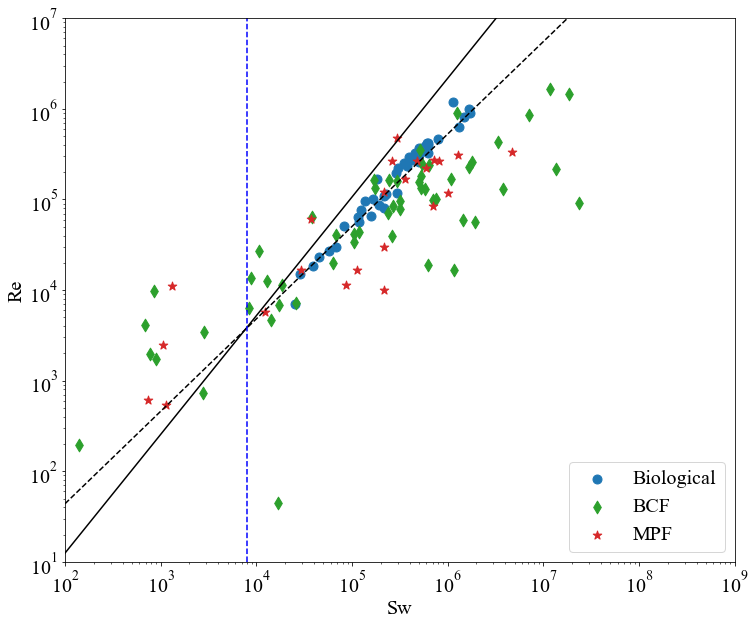

In [6]:
# plot Reynolds number and SW
fig1, ax1 = plt.subplots(figsize=(12,10), facecolor='w')

ax1.scatter(bio['Sw'], bio['Re'], marker='o', color='C0', label='Biological')
ax1.scatter(bcf['Sw'], bcf['Re'], marker='d', color='C2', label='BCF')

# if len(bcf_low) > 2:
#     ax4.plot(bcf_low['Sw'], bcf_fit_low.params['a'].value*bcf_low['Sw']**bcf_fit_low.params['b'].value, 'C2--')
#     ax4.plot(bcf_high['Sw'], bcf_fit_high.params['a'].value*bcf_high['Sw']**bcf_fit_high.params['b'].value, 'C2--')
# else:
#     ax4.plot(bcf['Sw'], bcf_fit.params['a'].value*bcf['Sw'].values**bcf_fit.params['b'].value, 'C2--', 
#          label=str(np.round(bcf_fit.params['a'].value, 2)) + '$\mathrm{M^{' + str(np.round(bcf_fit.params['b'].value,2)) + '}}$')

ax1.scatter(mpf['Sw'], mpf['Re'], marker='*', color='C3', label='MPF')

# if len(mpf_low) > 2:
#     ax4.plot(mpf_low['Sw'], mpf_fit_low.params['a'].value*mpf_low['Sw']**mpf_fit_low.params['b'].value, 'C3--')
#     ax4.plot(mpf_high['Sw'], mpf_fit_high.params['a'].value*mpf_high['Sw']**mpf_fit_high.params['b'].value, 'C3--')
# else:
#     ax4.plot(mpf['Sw'], mpf_fit.params['a'].value*mpf['Sw'].values**bcf_fit.params['b'].value, 'C3--', 
#         label=str(np.round(mpf_fit.params['a'].value, 2)) + '$\mathrm{M^{' + str(np.round(mpf_fit.params['b'].value,2)) + '}}$')

dx = np.linspace(1e2, 1e8)
Re_low = 0.03*dx**1.31
Re_high = 0.4*dx**1.02

ax1.plot(dx, Re_low, 'k-')
ax1.plot(dx, Re_high, 'k--')
ax1.plot([8e3, 8e3], [1e1, 1e9], 'b--')

ax1.set_xlabel('Sw')
ax1.set_ylabel('Re')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([1e1, 1e7])
ax1.set_xlim([1e2, 1e9])
ax1.legend(loc=4)
#fig1.savefig('robot_sw.pdf', facecolor='w', dpi=300, bbox_inches='tight')

In [7]:
# break up the data frame into perspective locomotion modes
sim_modes = gazzola_simDF['Simulation Type'].unique()
gazzola_sim_dfs = [gazzola_simDF[gazzola_simDF['Simulation Type']==mode] for mode in sim_modes]
bio_modes = gazzola_bioDF['Type'].unique()
gazzola_bio_dfs = [gazzola_bioDF[gazzola_bioDF['Type']==mode] for mode in bio_modes]

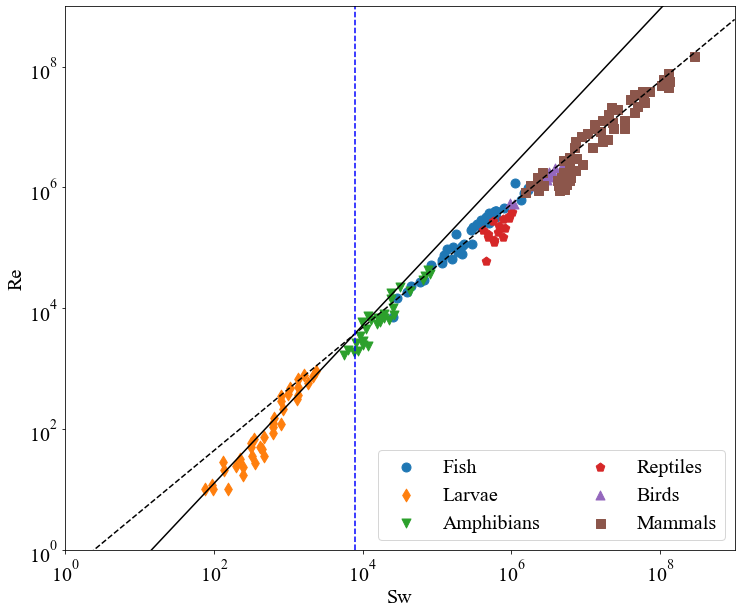

In [8]:
# plot Reynolds number and SW
fig2, ax2 = plt.subplots(figsize=(12,10), facecolor='w')

markers = ['d', 'v', 'p', '^', 's']

ax2.scatter(bio['Sw'], bio['Re'], marker='o', label='Fish')

for i, mode in enumerate(bio_modes):
    ax2.scatter(gazzola_bio_dfs[i]['Sw'], gazzola_bio_dfs[i]['Re'], marker=markers[i], label=mode  )


dx = np.linspace(1, 1e9)
Re_low = 0.03*dx**1.31
Re_high = 0.4*dx**1.02

ax2.plot(dx, Re_low, 'k-')
ax2.plot(dx, Re_high, 'k--')
ax2.plot([8e3, 8e3], [1, 1e9], 'b--')

ax2.set_xlabel('Sw')
ax2.set_ylabel('Re')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim([1, 1e9])
ax2.set_xlim([1, 1e9])
ax2.legend(ncol=2)
#fig2.savefig('biological_sw.pdf', facecolor='w', dpi=300, bbox_inches='tight')

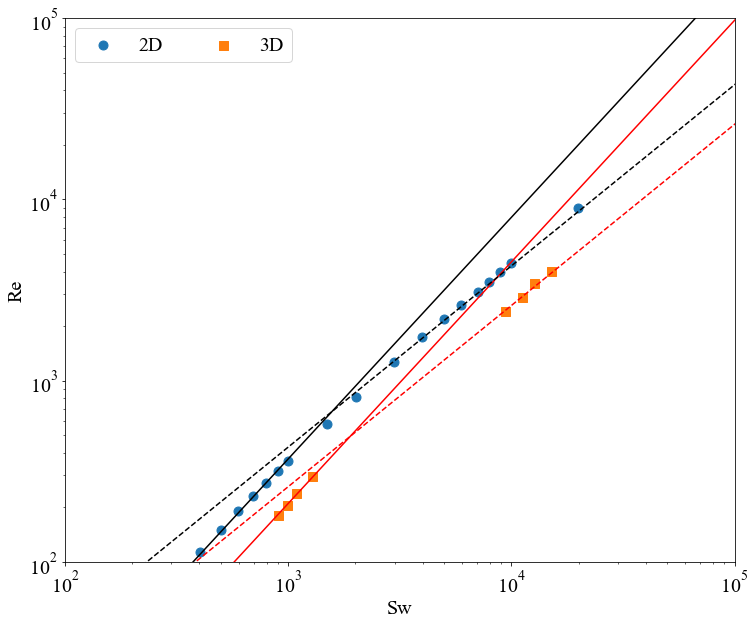

In [17]:
# plot Reynolds number and SW
fig3, ax3 = plt.subplots(figsize=(12,10), facecolor='w')

markers = ['o', 's', 'p', '^', 's']

for i, mode in enumerate(sim_modes):
    ax3.scatter(gazzola_sim_dfs[i]['Sw'], gazzola_sim_dfs[i]['Re'], marker=markers[i], label=mode  )


dx = np.linspace(1, 1e9)
Re_low = 0.021*dx**(4/3)
Re_high = 0.26*dx

ax3.plot(dx, Re_low, 'r-')
ax3.plot(dx, Re_high, 'r--')

Re_low = 0.037*dx**(4/3)
Re_high = 0.43*dx

ax3.plot(dx, Re_low, 'k-')
ax3.plot(dx, Re_high, 'k--')

ax3.set_xlabel('Sw')
ax3.set_ylabel('Re')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim([1e2, 1e5])
ax3.set_xlim([1e2, 1e5])
ax3.legend(ncol=2)
fig3.savefig('simulation_sw.pdf', facecolor='w', dpi=300, bbox_inches='tight')